In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd

In [3]:
# given point

In [4]:
# read in tile_points.csv
points = pd.read_csv('../../data/tile_points.csv')

In [5]:
row = points.iloc[10000]

In [6]:
# find enclosing tile

In [2]:
import geopandas as gpd

In [3]:
from nbhd.data import Base

Initializing database connection...
Database connected!


In [4]:
db = Base()

In [5]:
from nbhd.geography import Neighbourhood

In [6]:
n = Neighbourhood(load=False)#row.x, row.y, 

In [7]:
# nearest roads ~ 'slimroads' is without motorways and secondary roads

In [8]:
nr_roads = n.db.nearest_neighbours('slimroads', n.geom.buffer(10))

In [9]:
# nearest buildings

In [10]:
nr_buildings = n.db.nearest_neighbours('openmaplocal', n.geom.buffer(1))

In [11]:
# merge on UPRN

In [12]:
df = nr_buildings.merge(nr_roads, on=['UPRN', 'uprn_geometry'], how='inner', suffixes=('_building', '_street'))

In [13]:
del(nr_buildings)
del(nr_roads)

In [14]:
# 1 eliminate non-building properties : distance to building must == 0

In [15]:
df1 = df.loc[df.dist_building==0]

In [16]:
# 2 eliminate non-residential buildings : area / uprn count must < 250

In [17]:
building_counts = dict(df1.id_building.value_counts())

In [18]:
df1['building_counts'] = df1.id_building.apply(lambda x: building_counts.get(x, 0))

<ipython-input-18-909eb256e9a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['building_counts'] = df1.id_building.apply(lambda x: building_counts.get(x, 0))


In [19]:
df1['footprint_area'] = gpd.GeoSeries(df1.geometry_building).area
df1['footprint_area_per_uprn'] = df1.footprint_area / df1.building_counts

<ipython-input-19-5ba437b08873>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['footprint_area'] = gpd.GeoSeries(df1.geometry_building).area
<ipython-input-19-5ba437b08873>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['footprint_area_per_uprn'] = df1.footprint_area / df1.building_counts


In [20]:
df1['residential_building'] = df1['footprint_area_per_uprn'] < 250

<ipython-input-20-dd708221cae7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['residential_building'] = df1['footprint_area_per_uprn'] < 250


In [21]:
df2 = df1.loc[df1.residential_building]

In [22]:
# 3 establish whether roads are residential : length / uprn count must < 5??

In [23]:
street_counts = dict(df2.id_street.value_counts())

In [24]:
df2['street_counts'] = df2.id_street.apply(lambda x: street_counts.get(x, 0))

<ipython-input-24-be680ec1f918>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['street_counts'] = df2.id_street.apply(lambda x: street_counts.get(x, 0))


In [25]:
df2['street_length_per_uprn'] = df2.length / df2.street_counts

<ipython-input-25-0dd6277d304b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['street_length_per_uprn'] = df2.length / df2.street_counts


In [31]:
df2['residential_street'] = df2.street_length_per_uprn < 20
df2['short_street'] = df2.length < 20
df2['res_or_short'] = df2.residential_street | df2.short_street

CPU times: user 4.19 ms, sys: 5.32 ms, total: 9.51 ms
Wall time: 5.25 ms


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
df3 = df2.loc[df2.res_or_short]

In [23]:
# residential = dict(zip(df2.id_street, df2.residential_street))

In [24]:
# df['residential_street'] = df.id_street.apply(lambda x: residential.get(x, False))

In [42]:
# 4 find connected networks of residential streets

In [40]:
df3.columns

Index(['UPRN', 'uprn_geometry', 'id_building', 'featureCode',
       'geometry_building', 'dist_building', 'id_street', 'endNode',
       'startNode', 'roadNumberTOID', 'roadNameTOID', 'fictitious',
       'roadClassification', 'roadFunction', 'formOfWay', 'length',
       'length_uom', 'loop', 'primaryRoute', 'trunkRoad',
       'roadClassificationNumber', 'name1', 'name1_lang', 'name2',
       'name2_lang', 'roadStructure', 'geometry_street', 'dist_street',
       'building_counts', 'footprint_area', 'footprint_area_per_uprn',
       'residential_building', 'street_counts', 'street_length_per_uprn',
       'residential_street', 'short_street', 'res_or_short'],
      dtype='object')

In [45]:
streets3 = df3[['id_street', 'startNode', 'endNode', 'length', 'roadFunction', 'geometry_street']]

In [46]:
streets = df[['id_street', 'startNode', 'endNode', 'length', 'roadFunction', 'geometry_street']]

In [47]:
streets_gdf3 = gpd.GeoDataFrame(df3, geometry='geometry_street')

In [48]:
streets_gdf = gpd.GeoDataFrame(df, geometry='geometry_street')

<AxesSubplot:>

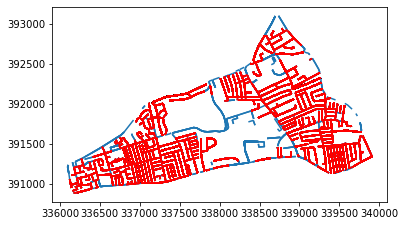

In [55]:
t = streets_gdf.plot()
streets_gdf3.plot(color='red', ax=t.axes)

In [34]:
import networkx as nx

In [136]:
edges = streets3.loc[~streets3.duplicated()]

In [137]:
g = nx.from_pandas_edgelist(edges, 'startNode', 'endNode', True)

In [138]:
subgraphs =[g.subgraph(c) for c in nx.connected_components(g)]

In [139]:
subgraph_edges = [sg.edges for sg in subgraphs]

In [ ]:
# 5 find connected networks of residential and non-(B Road/ Minor Road) streets